<a href="https://colab.research.google.com/github/JReds12/KL_invasive_python_ID_model/blob/main/CWS_model__kl_invasive_pythons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Nonindigenous Python Species Found in Key Largo: Burmese Python (*Python bivittatus*) & Ball Pythons (*Python regius*) 


While invasive Burmese pythons have been established in Key Largo, FL since 2016, ball pythons do not yet have a stable reproducing population on the island. Ball python sightings and removals are likely released pets. However, they might become invasive given their life history. Some residents of Key Largo's general public might not be able to distinguish between these two non-indigenous python species. Creating a computer vision model and app that classifies python photos might help expidite reporting and removal efforts of invasive pythons. 

**Scape Photos From Internet**

In [ ]:
#import the image scraper by @JoeDockrill, website: https://joedockrill.github.io/blog/2020/09/18/jmd-imagescraper-library/
!pip install -q jmd_imagescraper

from jmd_imagescraper.core import * 
from pathlib import Path
from jmd_imagescraper.imagecleaner import *

In [ ]:
#Create Path
path = Path("/content/drive/MyDrive/computer_vision_photos/key_largo_invasive_pythons") 

In [ ]:
#Create new folders with new headings
animals = ['burmese python','ball python'] # add other species later?

In [ ]:
#Scrape Burmese python photos
duckduckgo_search(path,"burmese python", "Python bivittatus", max_results = 200) # over 200 max_results gives too many duplicates and other python species

In [ ]:
#Start with a small number of images, note these will not overwrite repeats
duckduckgo_search(path,"ball python", "Python regius", max_results = 200) # max_result sizes kept at 200 to keep sample sizes approximate

* Duplicate and inaccurate photos removed in google drive manually

**Training a CNN for Python Classification**

Creating model

In [ ]:
#Libraries
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
import base64
import pandas as pd
import os
import PIL
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

#from pathlib import Path
from numpy import *
import torch
print(torch.cuda.is_available())

True


In [ ]:
# set path to working directory in Google Drive
path = Path("/content/drive/MyDrive/computer_vision_photos/key_largo_invasive_pythons") 
dir_list = [x for x in path.iterdir() if x.is_dir()]
print(dir_list)
path.ls()

In [ ]:
# create model

np.random.seed(12)

python_id = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label,
                  item_tfms= Resize(300, 'squish'),
                  batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
#set batch size
dls = python_id.dataloaders(path, bs = 50) # look into how batch size might affect model accuracy

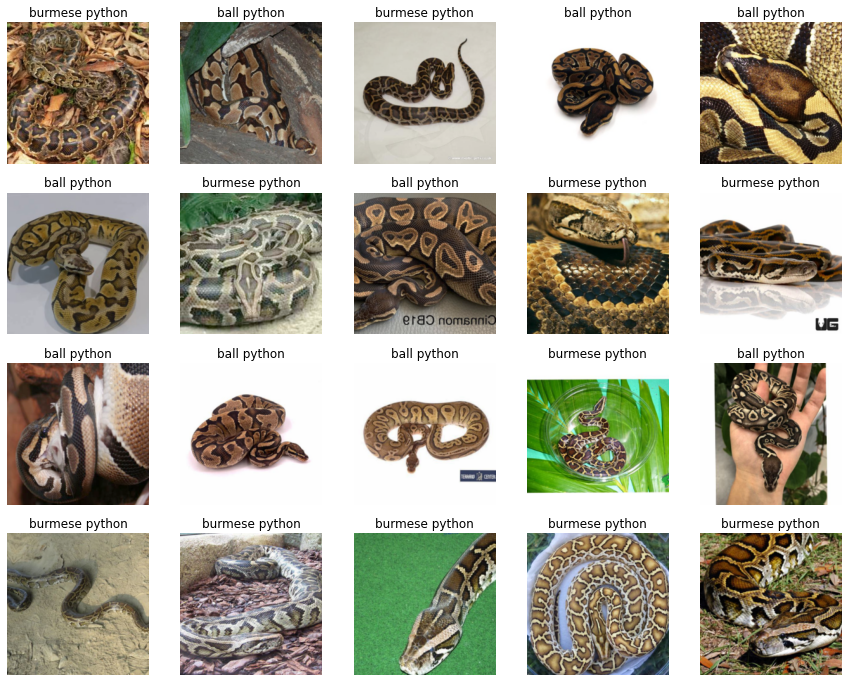

In [ ]:
#show batch
dls.show_batch(max_n = 20)

In [ ]:
#Checking the class label names
dls.vocab.o2i

{'ball python': 0, 'burmese python': 1}

Model Training

In [ ]:
#Generate the Learner 
learn = cnn_learner(dls, resnet101, pretrained = True, metrics = accuracy).to_fp16()

In [ ]:
#Initial Training (burn in)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.037744,0.261999,0.916667,00:24
1,0.563730,0.238632,0.937500,00:02
2,0.378112,0.214305,0.937500,00:02


In [ ]:
learn.unfreeze() #will freeze after each training

In [ ]:
# Trained on all layers
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.025292,0.086171,0.958333,00:03
1,0.591099,1.510674,0.833333,00:03
2,0.632466,1.978267,0.770833,00:03


In [ ]:
# Extra training
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.019746,5.206934,0.770833,00:04
1,0.031870,1.953930,0.833333,00:03
2,0.030609,0.727102,0.916667,00:03


In [ ]:
# With Transforms
learn.fit_one_cycle(3) # warped images above in original model

epoch,train_loss,valid_loss,accuracy,time
0,0.124299,0.352536,0.979167,00:05
1,0.153629,2.978516,0.854167,00:04
2,0.170228,1.695773,0.916667,00:03


In [ ]:
# Extra training - images reverted back to originals
learn.fit_one_cycle(8, , lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.070101,0.544447,0.937500,00:03
1,0.072521,0.276953,0.979167,00:03
2,0.093710,0.637438,0.958333,00:03


Save and Load Model

In [ ]:
learn.save('kl_python_model')
#learn.load('kl_python_model')

Path('models/kl_python_model.pth')

Interpretation

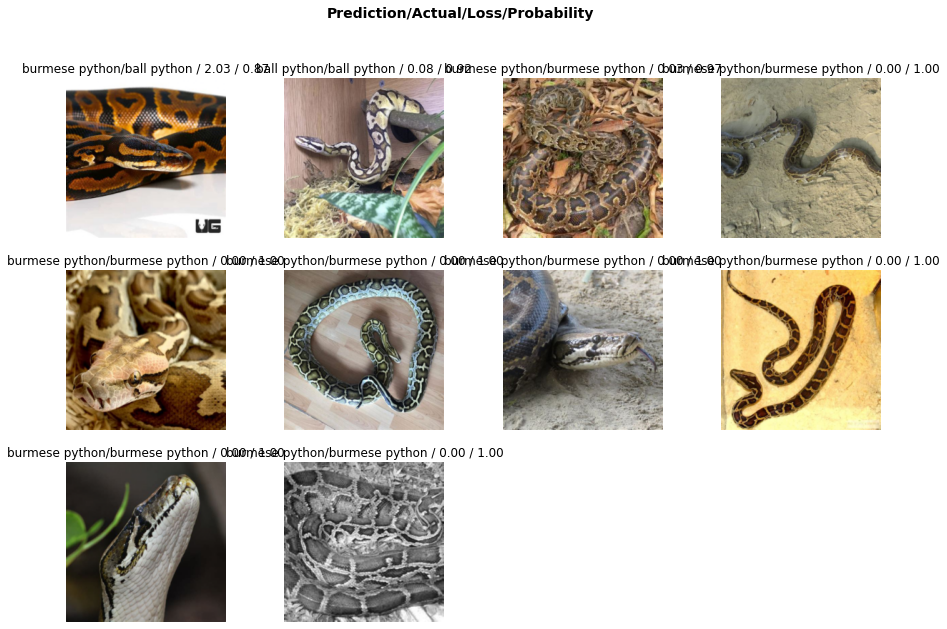

In [ ]:
interp.plot_top_losses(10, figsize=(15,10), largest=True) # head shots of pythons seem to give model issues, not sure on the rest (lighting?)

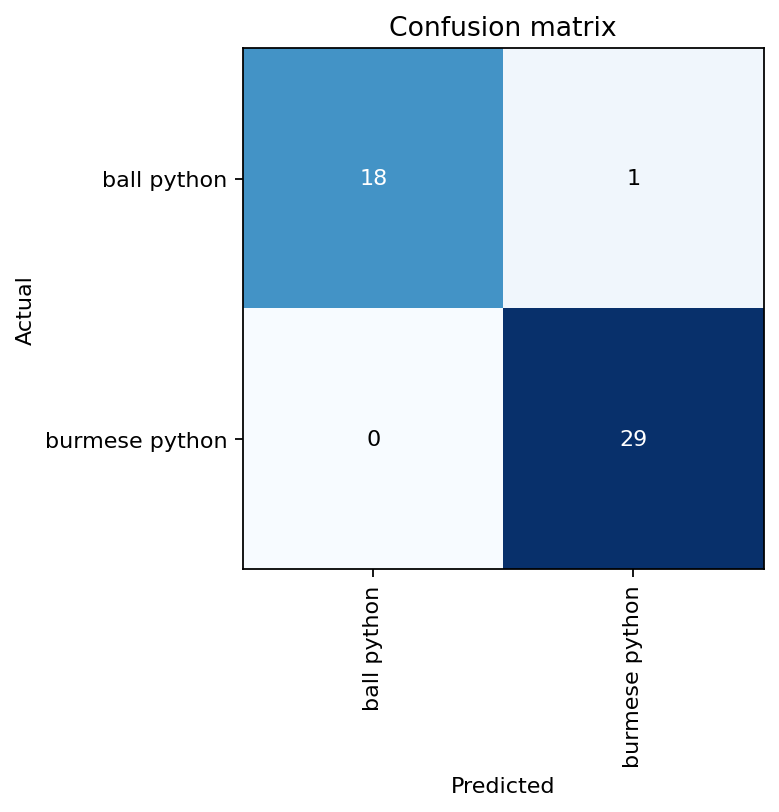

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=160)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
learn.lr_find() # this stopped working after model became more accurate - look into later

Save and Export Model

In [ ]:
learn.export('kl_python_model.pkl')